In [1]:
import os
import urllib
import zipfile
import time

import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
ratings = pd.read_csv('combined_data_fin.csv')
ratings['reviewer_id'] = pd.factorize(ratings['reviewer_id'])[0]
ratings['id'] = pd.factorize(ratings['id'])[0]
ratings = ratings.loc[:,['reviewer_id','id','ratings','listing_url']]
print(ratings.head())


/opt/apps/rhel8/Anaconda3-2021.05/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (66,67) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


   reviewer_id  id  ratings                        listing_url
0            0   0      4.5  https://www.airbnb.com/rooms/2818
1            1   0      5.0  https://www.airbnb.com/rooms/2818
2            2   0      5.0  https://www.airbnb.com/rooms/2818
3            3   0      5.0  https://www.airbnb.com/rooms/2818
4            4   0      5.0  https://www.airbnb.com/rooms/2818


In [4]:
ratings.to_csv("reviews_airbnb.csv")

In [3]:
X = ratings.loc[:,['reviewer_id','id']]
y = ratings.loc[:,'ratings']

# Split our data into training and test sets
X_train, X_val, y_train, y_val = train_test_split(X,y,random_state=0, test_size=0.2)

In [4]:
def prep_dataloaders(X_train,y_train,X_val,y_val,batch_size):
    # Convert training and test data to TensorDatasets
    trainset = TensorDataset(torch.from_numpy(np.array(X_train)).long(), 
                            torch.from_numpy(np.array(y_train)).float())
    valset = TensorDataset(torch.from_numpy(np.array(X_val)).long(), 
                            torch.from_numpy(np.array(y_val)).float())

    # Create Dataloaders for our training and test data to allow us to iterate over minibatches 
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
    valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False)

    return trainloader, valloader

batchsize = 64
trainloader,valloader = prep_dataloaders(X_train,y_train,X_val,y_val,batchsize)

In [5]:
class NNColabFiltering(nn.Module):
    
    def __init__(self, n_users, n_items, embedding_dim_users, embedding_dim_items, n_activations, rating_range):
        super().__init__()
        self.user_embeddings = nn.Embedding(num_embeddings=n_users,embedding_dim=embedding_dim_users)
        self.item_embeddings = nn.Embedding(num_embeddings=n_items,embedding_dim=embedding_dim_items)
        self.fc1 = nn.Linear(embedding_dim_users+embedding_dim_items,n_activations)
        self.fc2 = nn.Linear(n_activations,1)
        self.rating_range = rating_range

    def forward(self, X):
        # Get embeddings for minibatch
        embedded_users = self.user_embeddings(X[:,0])
        embedded_items = self.item_embeddings(X[:,1])
        # Concatenate user and item embeddings
        embeddings = torch.cat([embedded_users,embedded_items],dim=1)
        # Pass embeddings through network
        preds = self.fc1(embeddings)
        preds = F.relu(preds)
        preds = self.fc2(preds)
        # Scale predicted ratings to target-range [low,high]
        preds = torch.sigmoid(preds) * (self.rating_range[1]-self.rating_range[0]) + self.rating_range[0]
        return preds
        


In [6]:
def train_model(model, criterion, optimizer, dataloaders, device, num_epochs=5, scheduler=None):
    model = model.to(device) # Send model to GPU if available
    since = time.time()

    costpaths = {'train':[],'val':[]}
    #new
    best_val_loss = float('inf')
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0

            # Get the inputs and labels, and send to GPU if available
            for (inputs,labels) in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the weight gradients
                optimizer.zero_grad()

                # Forward pass to get outputs and calculate loss
                # Track gradient only for training data
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model.forward(inputs).view(-1)
                    loss = criterion(outputs, labels)

                    # Backpropagation to get the gradients with respect to each weight
                    # Only if in train
                    if phase == 'train':
                        loss.backward()
                        # Update the weights
                        optimizer.step()

                # Convert loss into a scalar and add it to running_loss
                running_loss += np.sqrt(loss.item()) * labels.size(0)

            # Step along learning rate scheduler when in train
            if (phase == 'train') and (scheduler is not None):
                scheduler.step()

            # Calculate and display average loss and accuracy for the epoch
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            costpaths[phase].append(epoch_loss)
            print('{} loss: {:.4f}'.format(phase, epoch_loss))
            #new
            if phase == 'val' and epoch_loss < best_val_loss:
                print('Validation loss decreased from {:.4f} to {:.4f}. Saving model...'.format(best_val_loss, epoch_loss))
                best_val_loss = epoch_loss
                torch.save(model.state_dict(), 'best_model_weights.pth')
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))

    return costpaths

In [7]:
# Train the model
dataloaders = {'train':trainloader, 'val':valloader}
n_users = X.loc[:,'reviewer_id'].max()+1
n_items = X.loc[:,'id'].max()+1
model = NNColabFiltering(n_users,n_items,embedding_dim_users=50, embedding_dim_items=50, n_activations = 100,rating_range=[0.,5.])
criterion = nn.MSELoss()
lr=0.001
n_epochs=10
wd=1e-3
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

cost_paths = train_model(model,criterion,optimizer,dataloaders, device,n_epochs, scheduler=None)


Epoch 0/9
----------
train loss: 0.6488
val loss: 0.6375
Validation loss decreased from inf to 0.6375. Saving model...
Epoch 1/9
----------
train loss: 0.6362
val loss: 0.6343
Validation loss decreased from 0.6375 to 0.6343. Saving model...
Epoch 2/9
----------
train loss: 0.6337
val loss: 0.6334
Validation loss decreased from 0.6343 to 0.6334. Saving model...
Epoch 3/9
----------
train loss: 0.6325
val loss: 0.6326
Validation loss decreased from 0.6334 to 0.6326. Saving model...
Epoch 4/9
----------
train loss: 0.6320
val loss: 0.6333
Epoch 5/9
----------
train loss: 0.6323
val loss: 0.6324
Validation loss decreased from 0.6326 to 0.6324. Saving model...
Epoch 6/9
----------
train loss: 0.6320
val loss: 0.6325
Epoch 7/9
----------
train loss: 0.6320
val loss: 0.6324
Validation loss decreased from 0.6324 to 0.6324. Saving model...
Epoch 8/9
----------
train loss: 0.6320
val loss: 0.6322
Validation loss decreased from 0.6324 to 0.6322. Saving model...
Epoch 9/9
----------
train loss: 0.

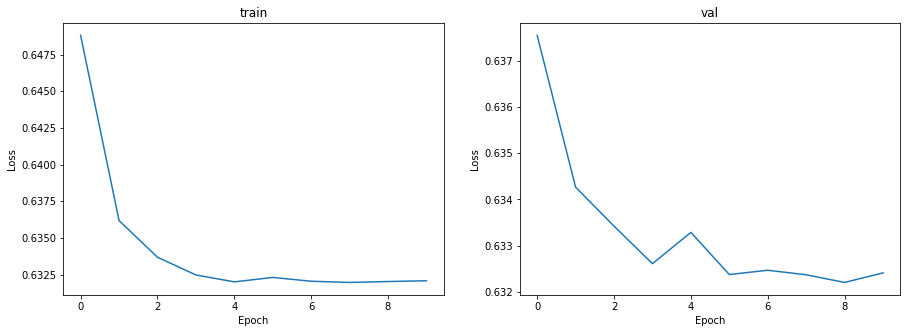

In [8]:
# Plot the cost over training and validation sets
fig,ax = plt.subplots(1,2,figsize=(15,5))
for i,key in enumerate(cost_paths.keys()):
    ax_sub=ax[i%3]
    ax_sub.plot(cost_paths[key])
    ax_sub.set_title(key)
    ax_sub.set_xlabel('Epoch')
    ax_sub.set_ylabel('Loss')
plt.show()